# Healthcare Survey Data Analysis

This notebook performs data visualization and analysis for the healthcare survey data:
1. Show ages with the highest income
2. Show gender distribution across spending categories
3. Export charts for presentations

## Setup and Data Loading

In [12]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import os
from datetime import datetime

# Configure display settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Set figure size defaults
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Healthcare Survey Data Analysis")
print("=" * 40)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 40)

Healthcare Survey Data Analysis
Analysis Date: 2025-08-20 21:16:31


In [13]:
# Fetch data directly from MongoDB and save to temporary directory
import tempfile
import csv
import os
from pymongo import MongoClient
from datetime import datetime

try:
    print("Connecting to MongoDB...")
    
    # Connect to MongoDB
    mongo_uri = os.getenv('MONGO_URI', 'mongodb://mongodb:27017/healthcare_survey')
    client = MongoClient(mongo_uri)
    db = client.healthcare_survey
    
    # Fetch all survey responses
    responses = list(db.survey_responses.find())
    print(f"Found {len(responses)} survey responses in database")
    
    if responses:
        # Create temporary directory
        temp_dir = tempfile.mkdtemp()
        csv_path = os.path.join(temp_dir, 'survey_data.csv')
        charts_dir = os.path.join(temp_dir, 'charts')
        os.makedirs(charts_dir, exist_ok=True)
        
        # Convert MongoDB data to CSV format
        csv_data = []
        for response in responses:
            row = {
                'ID': str(response['_id']),
                'Age': response['age'],
                'Gender': response['gender'],
                'Total_Income': response['total_income'],
                'Utilities': response['expenses'].get('utilities', 0),
                'Entertainment': response['expenses'].get('entertainment', 0),
                'School_Fees': response['expenses'].get('school_fees', 0),
                'Shopping': response['expenses'].get('shopping', 0),
                'Healthcare': response['expenses'].get('healthcare', 0),
                'Total_Expenses': sum(response['expenses'].values()),
                'Created_At': response['created_at'].isoformat()
            }
            csv_data.append(row)
        
        # Write to CSV file
        with open(csv_path, 'w', newline='', encoding='utf-8') as file:
            if csv_data:
                headers = list(csv_data[0].keys())
                writer = csv.DictWriter(file, fieldnames=headers)
                writer.writeheader()
                writer.writerows(csv_data)
        
        print(f"Data successfully saved to temporary location")
        print(f"Temp directory: {temp_dir}")
        print(f"CSV file: {csv_path}")
        print(f"Charts directory: {charts_dir}")
    else:
        print("No data found in database")
        csv_path = None
        temp_dir = None
        charts_dir = None
        
except Exception as e:
    print(f"Error connecting to database: {e}")
    print("Make sure MongoDB is running (docker-compose up)")
    csv_path = None
    temp_dir = None
    charts_dir = None

Connecting to MongoDB...
Found 75 survey responses in database
Data successfully saved to temporary location
Temp directory: /tmp/tmp3oe4bs6b
CSV file: /tmp/tmp3oe4bs6b/survey_data.csv
Charts directory: /tmp/tmp3oe4bs6b/charts


In [14]:
# Load the CSV data from temporary directory
try:
    if csv_path and os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        print(f"Data loaded successfully from {csv_path}")
        
        print(f"\nDataset Info:")
        print(f"  Rows: {len(df):,}")
        print(f"  Columns: {len(df.columns)}")
        print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024:.1f} KB")
    else:
        print(f"CSV file not found or not created properly")
        print("Please ensure the API is running and data is available:")
        print("1. Start the Flask application: python app.py")
        print("2. Ensure survey data exists in the database")
        print("3. Re-run the previous cell to fetch data")
        df = None
    
except Exception as e:
    print(f"Error loading data: {e}")
    df = None

Data loaded successfully from /tmp/tmp3oe4bs6b/survey_data.csv

Dataset Info:
  Rows: 75
  Columns: 11
  Memory usage: 21.4 KB


In [15]:
# Analysis 1: Ages with highest income
if df is not None:
    # Create age groups for better analysis
    df['age_group'] = pd.cut(df['Age'], 
                            bins=[18, 25, 35, 45, 55, 70], 
                            labels=['18-25', '26-35', '36-45', '46-55', '56-70'])
    
    # Calculate average income by age group
    income_by_age = df.groupby('age_group')['Total_Income'].agg(['mean', 'median', 'count']).round(2)
    income_by_age.columns = ['Average Income', 'Median Income', 'Count']
    
    print("Income Analysis by Age Group")
    print("=" * 35)
    display(income_by_age)
    
    # Find top 10 individual ages with highest average income
    top_income_ages = df.groupby('Age')['Total_Income'].mean().sort_values(ascending=False).head(10)
    
    print("\nTop 10 Ages with Highest Average Income")
    print("=" * 40)
    for age, income in top_income_ages.items():
        count = len(df[df['Age'] == age])
        print(f"Age {age}: ${income:,.2f} (n={count})")

Income Analysis by Age Group


,Average Income,Median Income,Count
age_group,,,
18-25,5098.76,4681.34,12
26-35,5631.31,4238.03,32
36-45,3784.26,4042.44,21
46-55,3180.68,3179.94,6
56-70,6301.66,6301.66,2



Top 10 Ages with Highest Average Income
Age 33: $10,565.95 (n=3)
Age 32: $9,423.21 (n=4)
Age 21: $9,333.85 (n=1)
Age 36: $8,985.34 (n=1)
Age 25: $6,512.72 (n=4)
Age 34: $6,493.86 (n=1)
Age 64: $6,301.66 (n=2)
Age 26: $5,239.99 (n=4)
Age 30: $4,838.09 (n=1)
Age 27: $4,810.64 (n=4)


## Analysis 1: Ages with Highest Income

Chart saved: /tmp/tmp3oe4bs6b/charts/income_by_age_analysis.png


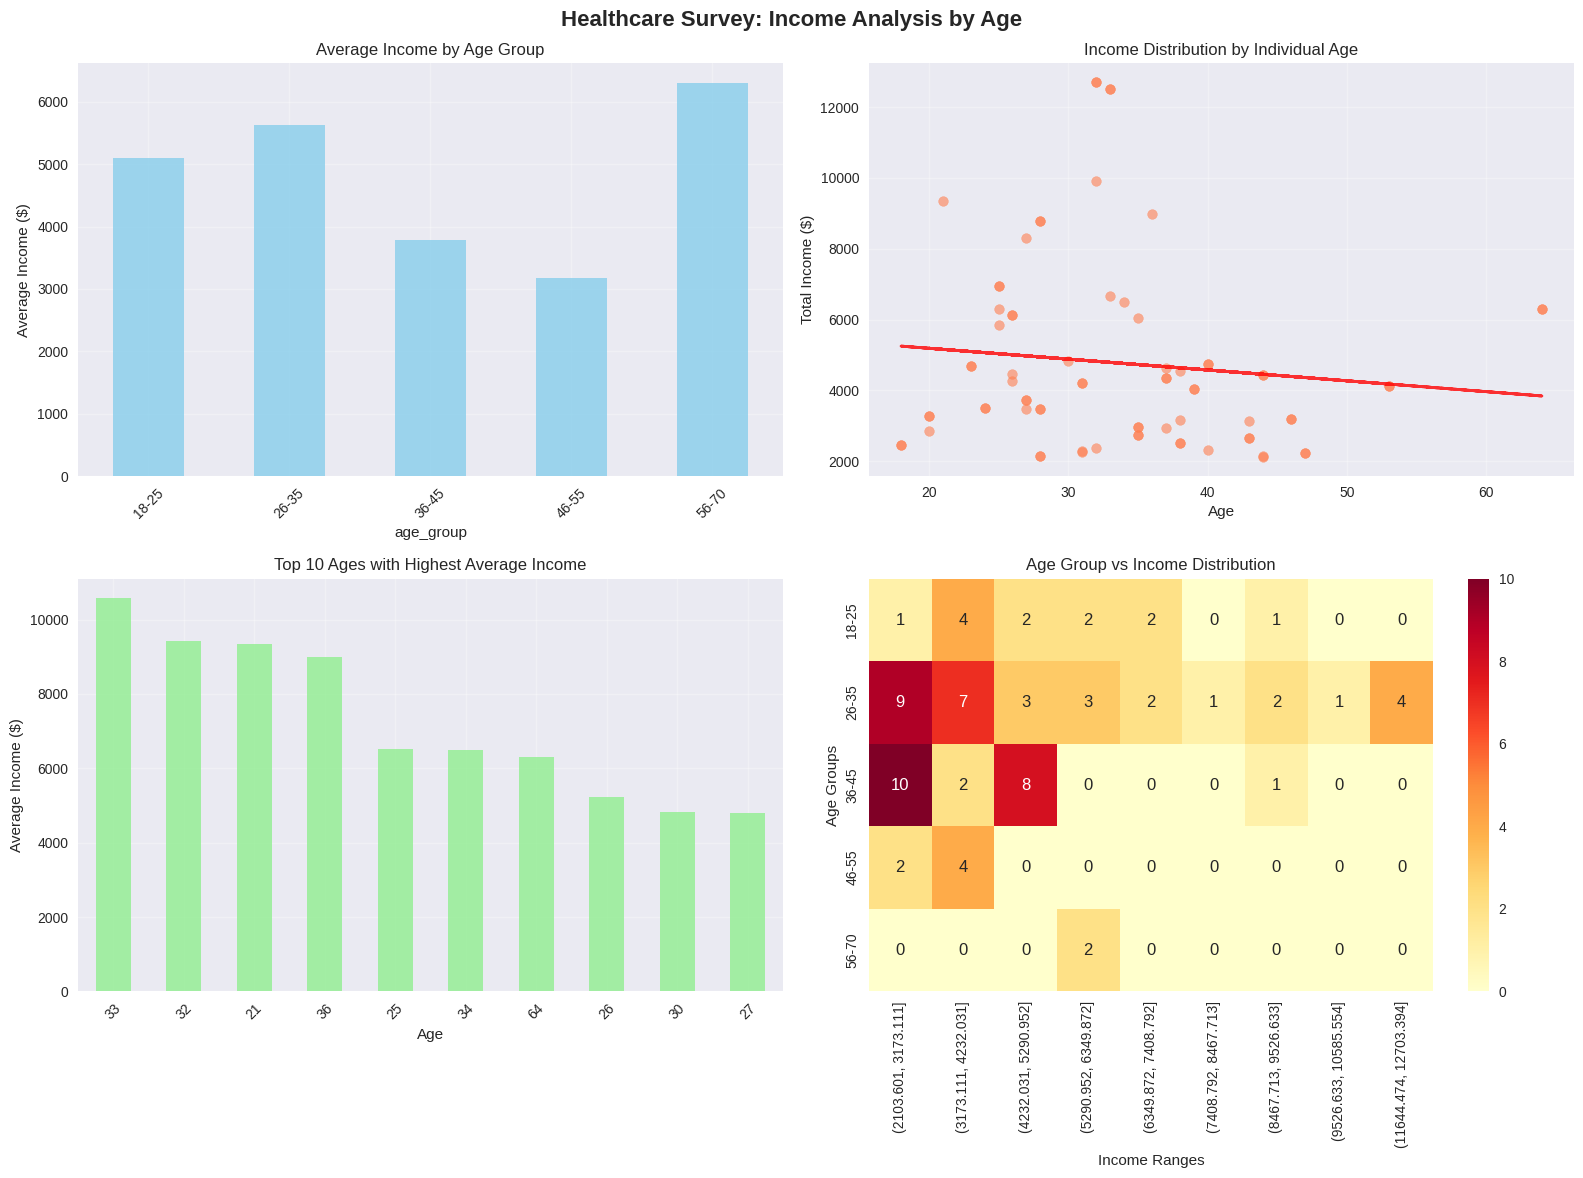

In [16]:
# Visualization 1: Ages with Highest Income
if df is not None:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Healthcare Survey: Income Analysis by Age', fontsize=16, fontweight='bold')
    
    # 1. Average income by age group (bar chart)
    income_by_age['Average Income'].plot(kind='bar', ax=axes[0,0], color='skyblue', alpha=0.8)
    axes[0,0].set_title('Average Income by Age Group')
    axes[0,0].set_ylabel('Average Income ($)')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Income distribution by age (scatter plot)
    axes[0,1].scatter(df['Age'], df['Total_Income'], alpha=0.6, color='coral')
    axes[0,1].set_title('Income Distribution by Individual Age')
    axes[0,1].set_xlabel('Age')
    axes[0,1].set_ylabel('Total Income ($)')
    axes[0,1].grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(df['Age'], df['Total_Income'], 1)
    p = np.poly1d(z)
    axes[0,1].plot(df['Age'], p(df['Age']), "r--", alpha=0.8, linewidth=2)
    
    # 3. Top 10 ages with highest income
    top_income_ages.plot(kind='bar', ax=axes[1,0], color='lightgreen', alpha=0.8)
    axes[1,0].set_title('Top 10 Ages with Highest Average Income')
    axes[1,0].set_ylabel('Average Income ($)')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Income vs Age heatmap
    # Create age bins for heatmap
    age_income_pivot = df.groupby(['Age'])['Total_Income'].mean().reset_index()
    age_income_matrix = age_income_pivot.set_index('Age')['Total_Income'].values.reshape(-1, 1)
    
    # Create income bins
    income_bins = pd.cut(df['Total_Income'], bins=10)
    age_income_cross = pd.crosstab(df['age_group'], income_bins)
    
    sns.heatmap(age_income_cross, ax=axes[1,1], cmap='YlOrRd', annot=True, fmt='d')
    axes[1,1].set_title('Age Group vs Income Distribution')
    axes[1,1].set_xlabel('Income Ranges')
    axes[1,1].set_ylabel('Age Groups')
    
    plt.tight_layout()
    
    # Save the chart to temporary directory
    if charts_dir:
        chart_path = os.path.join(charts_dir, 'income_by_age_analysis.png')
        plt.savefig(chart_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Chart saved: {chart_path}")
    
    plt.show()

## Analysis 2: Gender Distribution Across Spending Categories

In [17]:
# Analysis 2: Gender distribution across spending categories
if df is not None:
    # Calculate average spending by gender for each category
    expense_categories = ['Utilities', 'Entertainment', 'School_Fees', 'Shopping', 'Healthcare']
    
    gender_spending = df.groupby('Gender')[expense_categories].mean().round(2)
    
    print("Average Spending by Gender")
    print("=" * 35)
    display(gender_spending)
    
    # Calculate total spending by gender
    total_spending_by_gender = df.groupby('Gender')[expense_categories].sum()
    
    print("\nTotal Spending by Gender")
    print("=" * 30)
    display(total_spending_by_gender)
    
    # Calculate percentage distribution
    gender_spending_pct = df.groupby('Gender')[expense_categories].mean()
    gender_spending_pct_norm = gender_spending_pct.div(gender_spending_pct.sum(axis=0), axis=1) * 100
    
    print("\nPercentage Distribution by Category")
    print("=" * 40)
    display(gender_spending_pct_norm.round(1))

Average Spending by Gender


,Utilities,Entertainment,School_Fees,Shopping,Healthcare
Gender,,,,,
female,162.72,195.94,25.61,401.74,281.14
male,227.69,202.75,139.28,401.36,208.24
other,322.57,202.65,0.00,336.39,245.15



Total Spending by Gender


,Utilities,Entertainment,School_Fees,Shopping,Healthcare
Gender,,,,,
female,5532.541376,6661.905134,870.793707,13659.088599,9558.687233
male,8652.064945,7704.460749,5292.504624,15251.827595,7913.208821
other,967.701075,607.936687,0.000000,1009.158846,735.436453



Percentage Distribution by Category


,Utilities,Entertainment,School_Fees,Shopping,Healthcare
Gender,,,,,
female,22.8,32.6,15.5,35.3,38.3
male,31.9,33.7,84.5,35.2,28.4
other,45.2,33.7,0.0,29.5,33.4


Chart saved: /tmp/tmp3oe4bs6b/charts/gender_spending_distribution.png


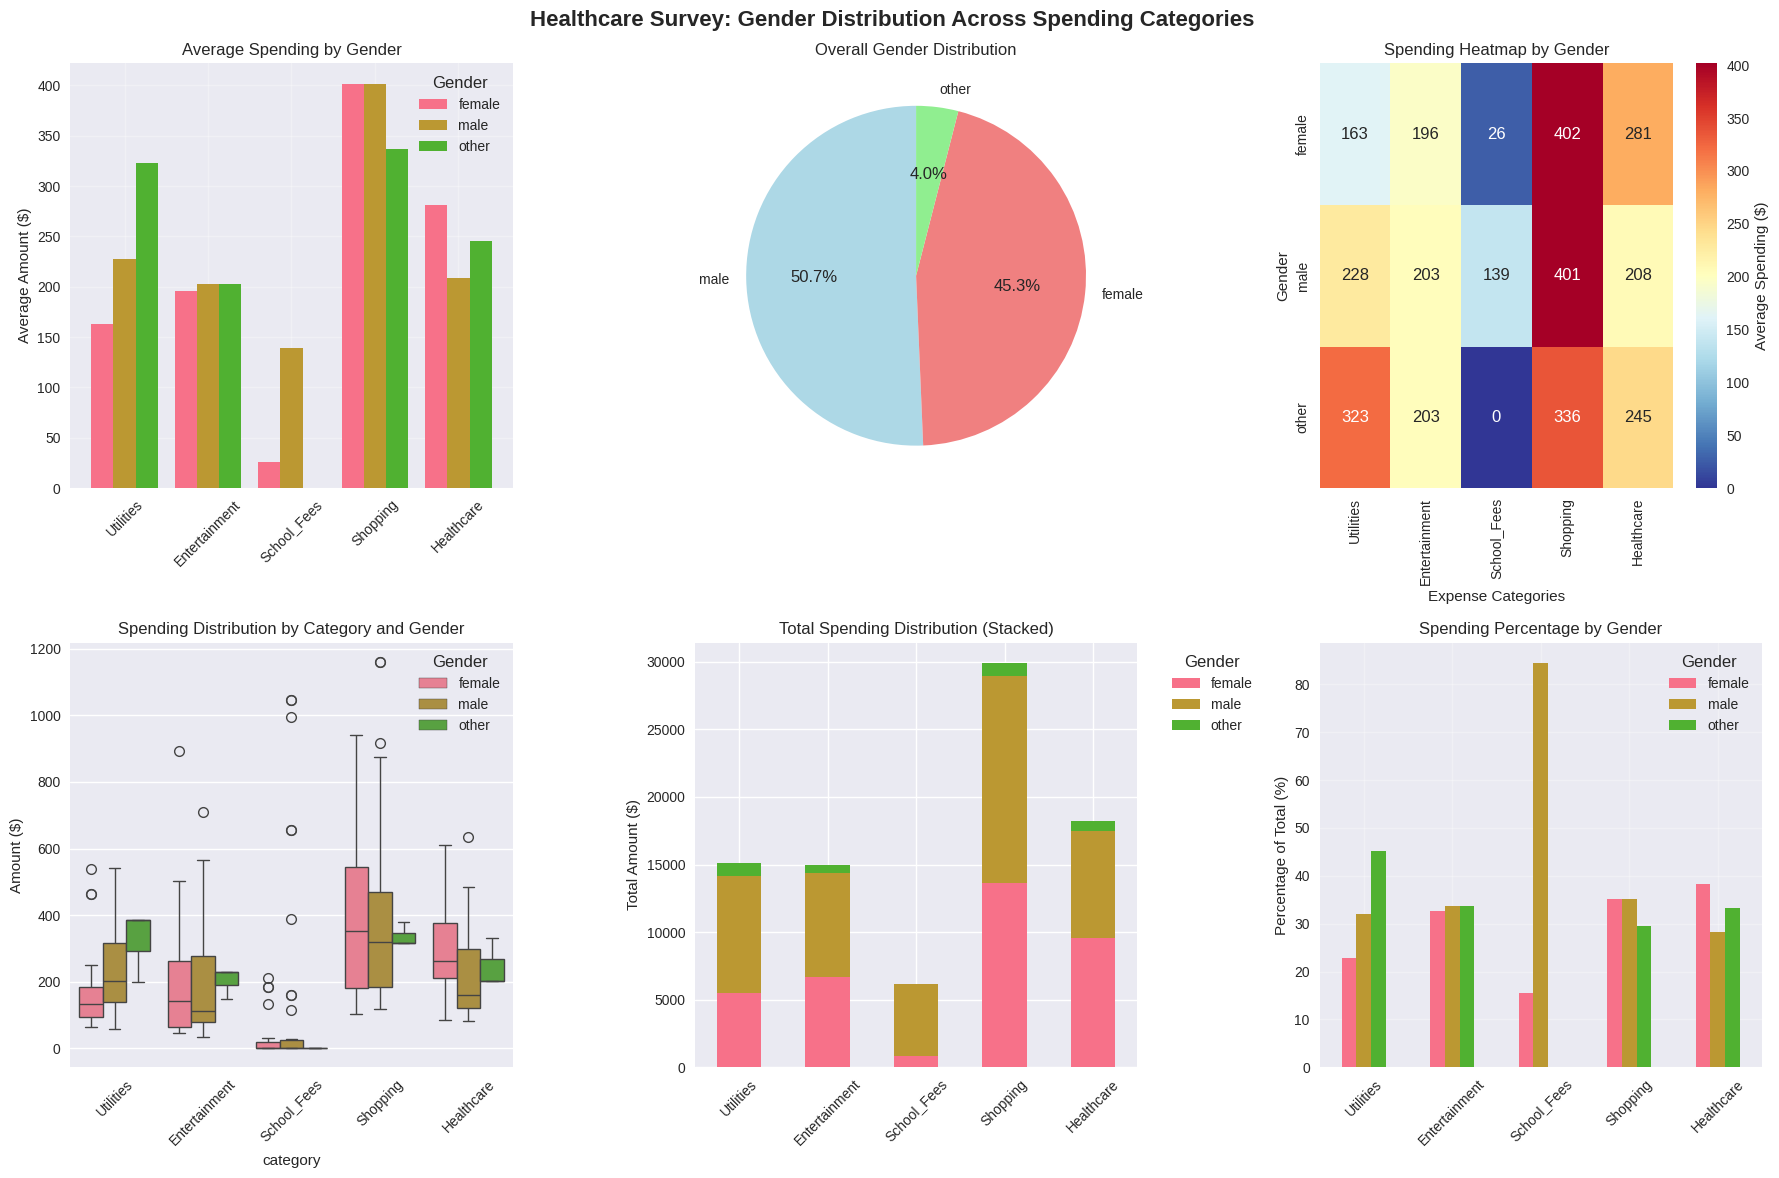

In [18]:
# Visualization 2: Gender Distribution Across Spending Categories
if df is not None:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Healthcare Survey: Gender Distribution Across Spending Categories', 
                 fontsize=16, fontweight='bold')
    
    # 1. Average spending by gender (grouped bar chart)
    gender_spending.T.plot(kind='bar', ax=axes[0,0], width=0.8)
    axes[0,0].set_title('Average Spending by Gender')
    axes[0,0].set_ylabel('Average Amount ($)')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].legend(title='Gender')
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Gender distribution pie chart
    gender_counts = df['Gender'].value_counts()
    colors = ['lightblue', 'lightcoral', 'lightgreen']
    axes[0,1].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', 
                  colors=colors, startangle=90)
    axes[0,1].set_title('Overall Gender Distribution')
    
    # 3. Spending patterns heatmap
    sns.heatmap(gender_spending, ax=axes[0,2], annot=True, fmt='.0f', 
                cmap='RdYlBu_r', cbar_kws={'label': 'Average Spending ($)'})
    axes[0,2].set_title('Spending Heatmap by Gender')
    axes[0,2].set_xlabel('Expense Categories')
    
    # 4. Box plots for each category by gender
    df_melted = df.melt(id_vars=['Gender'], value_vars=expense_categories, 
                        var_name='category', value_name='amount')
    
    sns.boxplot(data=df_melted, x='category', y='amount', hue='Gender', ax=axes[1,0])
    axes[1,0].set_title('Spending Distribution by Category and Gender')
    axes[1,0].set_ylabel('Amount ($)')
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # 5. Stacked bar chart showing total spending
    total_spending_by_gender.T.plot(kind='bar', stacked=True, ax=axes[1,1])
    axes[1,1].set_title('Total Spending Distribution (Stacked)')
    axes[1,1].set_ylabel('Total Amount ($)')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 6. Percentage comparison
    gender_spending_pct_norm.T.plot(kind='bar', ax=axes[1,2])
    axes[1,2].set_title('Spending Percentage by Gender')
    axes[1,2].set_ylabel('Percentage of Total (%)')
    axes[1,2].tick_params(axis='x', rotation=45)
    axes[1,2].legend(title='Gender')
    axes[1,2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save the chart to temporary directory
    if charts_dir:
        chart_path = os.path.join(charts_dir, 'gender_spending_distribution.png')
        plt.savefig(chart_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Chart saved: {chart_path}")
    
    plt.show()

## Interactive Visualizations with Plotly

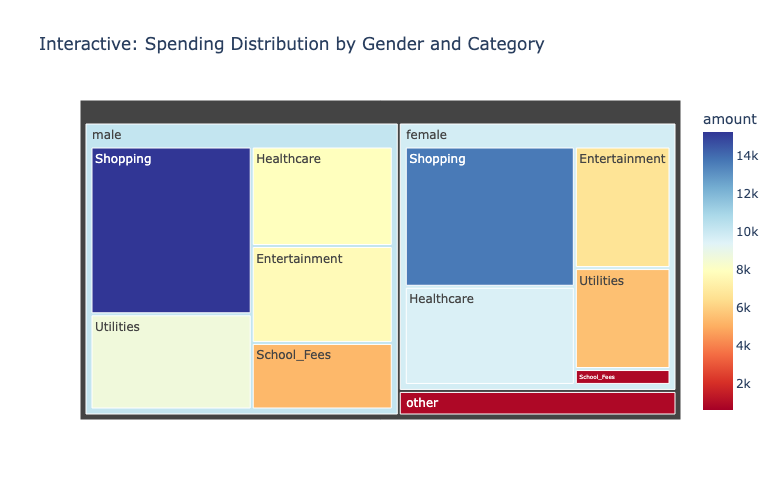

Interactive chart saved: /tmp/tmp3oe4bs6b/charts/interactive_gender_spending.html


In [19]:
# Interactive visualization 2: Gender spending breakdown
if df is not None:
    # Create sunburst chart for spending categories by gender
    spending_data = []
    for gender in df['Gender'].unique():
        gender_data = df[df['Gender'] == gender]
        for category in expense_categories:
            amount = gender_data[category].sum()
            # Only include non-zero amounts to avoid treemap errors
            if amount > 0.01:  # Filter out zero or very small values
                spending_data.append({
                    'gender': gender,
                    'category': category,
                    'amount': amount
                })
    
    spending_df = pd.DataFrame(spending_data)
    
    # Only create treemap if we have data
    if not spending_df.empty:
        # Create treemap
        fig = px.treemap(spending_df, path=['gender', 'category'], values='amount',
                         title='Interactive: Spending Distribution by Gender and Category',
                         color='amount', color_continuous_scale='RdYlBu')
        
        fig.update_layout(width=800, height=500)
        fig.show()
        
        # Save as HTML to temporary directory
        if charts_dir:
            html_path = os.path.join(charts_dir, 'interactive_gender_spending.html')
            fig.write_html(html_path)
            print(f"Interactive chart saved: {html_path}")
    else:
        print("No spending data available for treemap visualization")

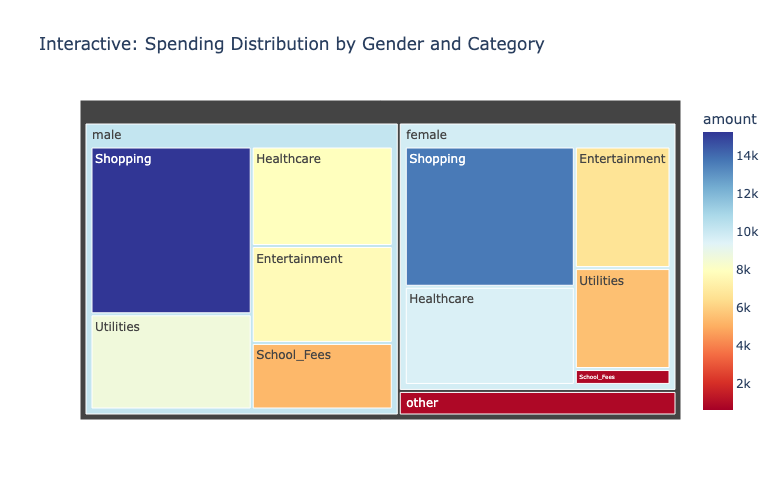

Interactive chart saved: /tmp/tmp3oe4bs6b/charts/interactive_gender_spending.html


In [20]:
# Interactive visualization 2: Gender spending breakdown
if df is not None:
    # Create sunburst chart for spending categories by gender
    spending_data = []
    for gender in df['Gender'].unique():
        gender_data = df[df['Gender'] == gender]
        for category in expense_categories:
            amount = gender_data[category].sum()
            # Only include non-zero amounts to avoid treemap errors
            if amount > 0.01:  # Filter out zero or very small values
                spending_data.append({
                    'gender': gender,
                    'category': category,
                    'amount': amount
                })
    
    spending_df = pd.DataFrame(spending_data)
    
    # Only create treemap if we have data
    if not spending_df.empty:
        # Create treemap
        fig = px.treemap(spending_df, path=['gender', 'category'], values='amount',
                         title='Interactive: Spending Distribution by Gender and Category',
                         color='amount', color_continuous_scale='RdYlBu')
        
        fig.update_layout(width=800, height=500)
        fig.show()
        
        # Save as HTML to temporary directory
        if charts_dir:
            html_path = os.path.join(charts_dir, 'interactive_gender_spending.html')
            fig.write_html(html_path)
            print(f"Interactive chart saved: {html_path}")
    else:
        print("No spending data available for treemap visualization")

In [21]:
# Additional analysis: Healthcare spending insights
if df is not None:
    print("Healthcare Spending Analysis")
    print("=" * 35)
    
    # Healthcare spending by age group
    healthcare_by_age = df.groupby('age_group')['Healthcare'].agg(['mean', 'median', 'std']).round(2)
    healthcare_by_age.columns = ['Mean', 'Median', 'Std Dev']
    
    print("Healthcare Spending by Age Group:")
    display(healthcare_by_age)
    
    # Healthcare spending by gender
    healthcare_by_gender = df.groupby('Gender')['Healthcare'].agg(['mean', 'median', 'count']).round(2)
    healthcare_by_gender.columns = ['Mean', 'Median', 'Count']
    
    print("\nHealthcare Spending by Gender:")
    display(healthcare_by_gender)
    
    # Income vs Healthcare spending correlation
    correlation = df['Total_Income'].corr(df['Healthcare'])
    print(f"\nCorrelation between Income and Healthcare Spending: {correlation:.3f}")
    
    # Find users spending most on healthcare
    top_healthcare_spenders = df.nlargest(5, 'Healthcare')[['Age', 'Gender', 'Total_Income', 'Healthcare']]
    print("\nTop 5 Healthcare Spenders:")
    display(top_healthcare_spenders)

Healthcare Spending Analysis
Healthcare Spending by Age Group:


,Mean,Median,Std Dev
age_group,,,
18-25,247.94,210.81,158.50
26-35,284.95,275.53,145.97
36-45,203.58,221.99,83.01
46-55,163.69,94.42,109.34
56-70,218.13,218.13,0.00



Healthcare Spending by Gender:


,Mean,Median,Count
Gender,,,
female,281.14,262.11,34
male,208.24,160.97,38
other,245.15,202.09,3



Correlation between Income and Healthcare Spending: 0.025

Top 5 Healthcare Spenders:


,Age,Gender,Total_Income,Healthcare
25,25,male,5845.285409,633.961234
47,31,female,2254.546252,609.589617
5,31,male,4202.332688,485.387360
55,31,male,4202.332688,485.387360
45,33,female,6676.493096,473.591360


Chart saved: /tmp/tmp3oe4bs6b/charts/executive_summary_dashboard.png


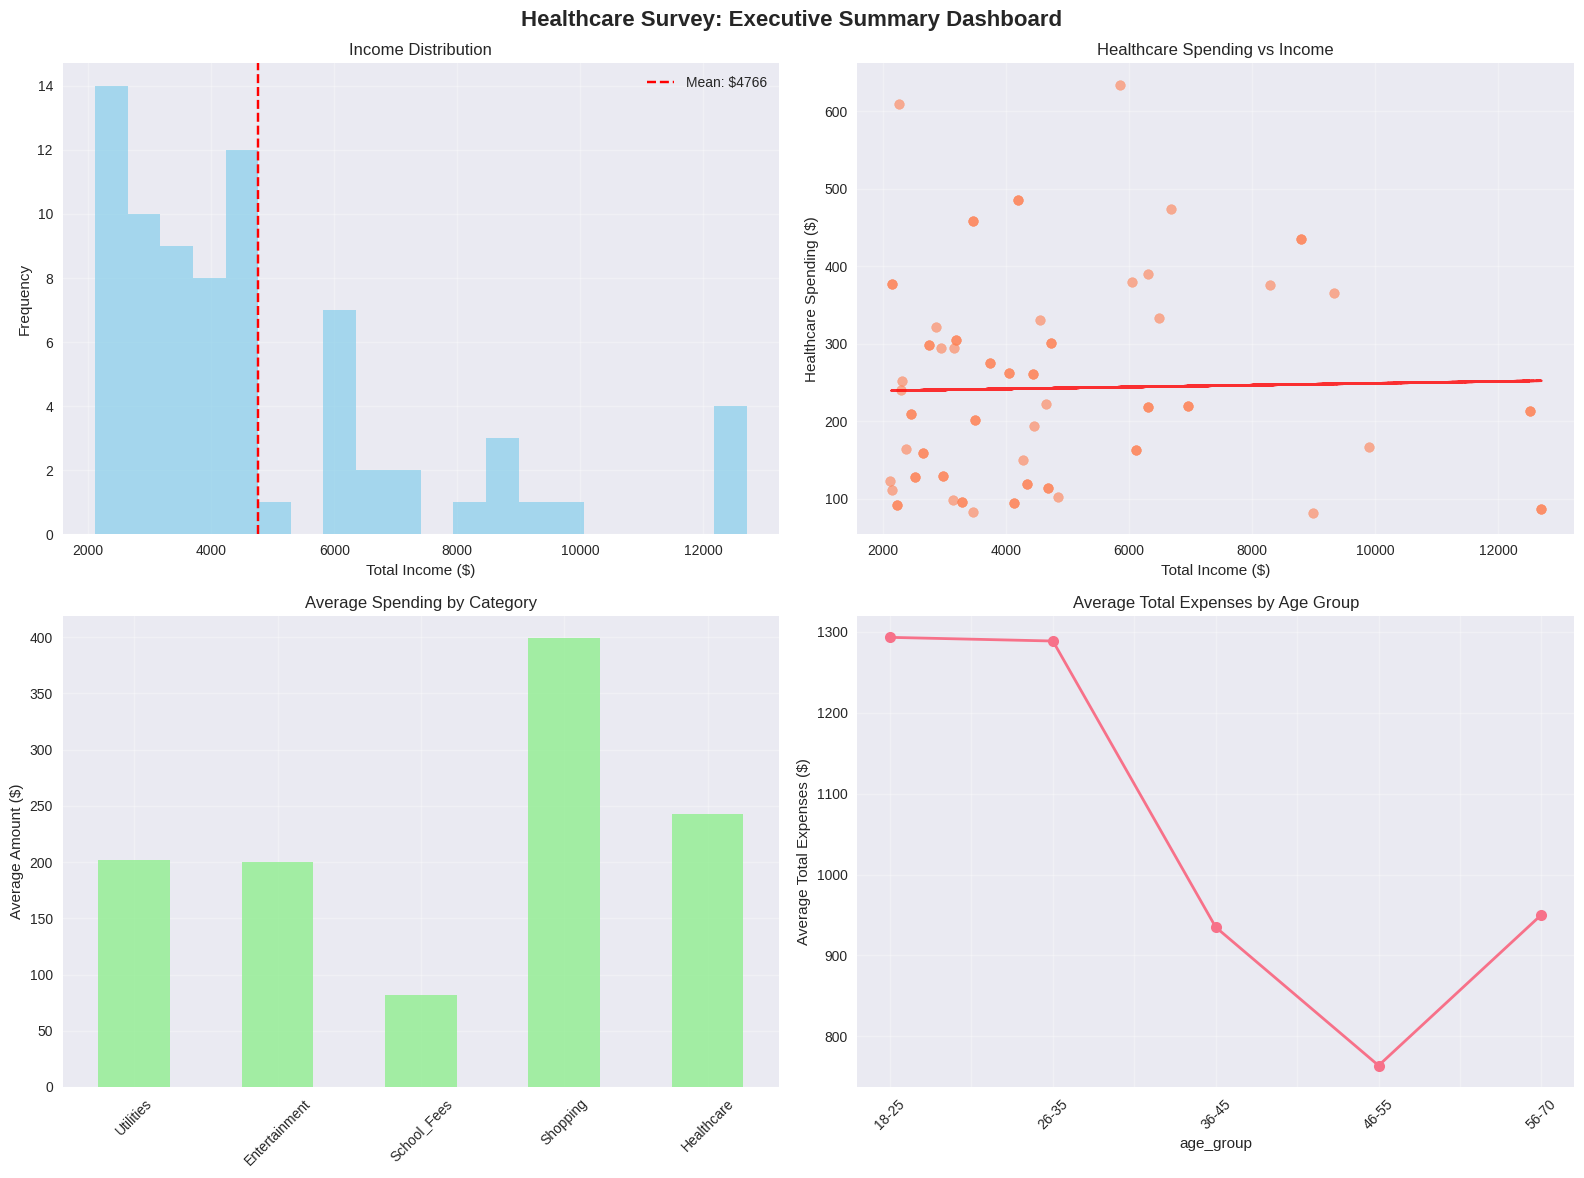

In [22]:
# Create summary dashboard
if df is not None:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Healthcare Survey: Executive Summary Dashboard', 
                 fontsize=16, fontweight='bold')
    
    # 1. Income distribution
    df['Total_Income'].hist(bins=20, ax=axes[0,0], alpha=0.7, color='skyblue')
    axes[0,0].axvline(df['Total_Income'].mean(), color='red', linestyle='--', 
                      label=f'Mean: ${df["Total_Income"].mean():.0f}')
    axes[0,0].set_title('Income Distribution')
    axes[0,0].set_xlabel('Total Income ($)')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Healthcare spending vs income
    axes[0,1].scatter(df['Total_Income'], df['Healthcare'], alpha=0.6, color='coral')
    axes[0,1].set_title('Healthcare Spending vs Income')
    axes[0,1].set_xlabel('Total Income ($)')
    axes[0,1].set_ylabel('Healthcare Spending ($)')
    axes[0,1].grid(True, alpha=0.3)
    
    # Add trend line
    z = np.polyfit(df['Total_Income'], df['Healthcare'], 1)
    p = np.poly1d(z)
    axes[0,1].plot(df['Total_Income'], p(df['Total_Income']), "r--", alpha=0.8)
    
    # 3. Average spending by category
    avg_spending = df[expense_categories].mean()
    avg_spending.plot(kind='bar', ax=axes[1,0], color='lightgreen', alpha=0.8)
    axes[1,0].set_title('Average Spending by Category')
    axes[1,0].set_ylabel('Average Amount ($)')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Age vs total expenses
    age_expense_corr = df.groupby('age_group')['Total_Expenses'].mean()
    age_expense_corr.plot(kind='line', marker='o', ax=axes[1,1], linewidth=2, markersize=8)
    axes[1,1].set_title('Average Total Expenses by Age Group')
    axes[1,1].set_ylabel('Average Total Expenses ($)')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save the summary dashboard to temporary directory
    if charts_dir:
        chart_path = os.path.join(charts_dir, 'executive_summary_dashboard.png')
        plt.savefig(chart_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Chart saved: {chart_path}")
    
    plt.show()

In [23]:
# Generate final summary report
if df is not None:
    print("HEALTHCARE SURVEY ANALYSIS REPORT")
    print("=" * 40)
    
    print("\nKEY FINDINGS:")
    print("-" * 15)
    
    # Finding 1: Ages with highest income
    highest_income_age_group = income_by_age['Average Income'].idxmax()
    highest_income_amount = income_by_age.loc[highest_income_age_group, 'Average Income']
    print(f"1. HIGHEST INCOME AGE GROUP: {highest_income_age_group}")
    print(f"   Average Income: ${highest_income_amount:,.2f}")
    
    # Finding 2: Gender spending patterns
    print(f"\n2. GENDER SPENDING PATTERNS:")
    for gender in df['Gender'].unique():
        avg_total = df[df['Gender'] == gender]['Total_Expenses'].mean()
        highest_category = gender_spending.loc[gender].idxmax()
        highest_amount = gender_spending.loc[gender, highest_category]
        print(f"   {gender.title()}: Avg total ${avg_total:.0f}, Highest in {highest_category} (${highest_amount:.0f})")
    
    # Finding 3: Healthcare insights
    avg_healthcare_spending = df['Healthcare'].mean()
    healthcare_income_ratio = (avg_healthcare_spending / df['Total_Income'].mean()) * 100
    print(f"\n3. HEALTHCARE SPENDING:")
    print(f"   Average: ${avg_healthcare_spending:.2f}")
    print(f"   As % of income: {healthcare_income_ratio:.1f}%")
    
    print("\nRECOMMENDATIONS FOR PRODUCT LAUNCH:")
    print("-" * 35)
    print("1. Target the", highest_income_age_group, "age group for premium healthcare products")
    print("2. Develop gender-specific marketing strategies based on spending patterns")
    print("3. Consider income-based pricing tiers for healthcare services")
    print("4. Focus on preventive care products for younger demographics")
    print("5. Create comprehensive health packages for higher-income individuals")
    
    print("\nCHARTS EXPORTED FOR PRESENTATION:")
    print("-" * 35)
    if charts_dir:
        print(f"Charts saved to temporary directory: {charts_dir}")
        print("• income_by_age_analysis.png")
        print("• gender_spending_distribution.png")
        print("• executive_summary_dashboard.png")
        print("• interactive_income_by_age.html")
        print("• interactive_gender_spending.html")
    else:
        print("No charts directory available")
    
    print("\nAnalysis completed successfully!")

HEALTHCARE SURVEY ANALYSIS REPORT

KEY FINDINGS:
---------------
1. HIGHEST INCOME AGE GROUP: 56-70
   Average Income: $6,301.66

2. GENDER SPENDING PATTERNS:
   Female: Avg total $1067, Highest in Shopping ($402)
   Male: Avg total $1179, Highest in Shopping ($401)
   Other: Avg total $1107, Highest in Shopping ($336)

3. HEALTHCARE SPENDING:
   Average: $242.76
   As % of income: 5.1%

RECOMMENDATIONS FOR PRODUCT LAUNCH:
-----------------------------------
1. Target the 56-70 age group for premium healthcare products
2. Develop gender-specific marketing strategies based on spending patterns
3. Consider income-based pricing tiers for healthcare services
4. Focus on preventive care products for younger demographics
5. Create comprehensive health packages for higher-income individuals

CHARTS EXPORTED FOR PRESENTATION:
-----------------------------------
Charts saved to temporary directory: /tmp/tmp3oe4bs6b/charts
• income_by_age_analysis.png
• gender_spending_distribution.png
• executi